## Extract

- How (link): https://www.kaggle.com/datasets/kartik2112/fraud-detection

- How (cvs file from link on page below): FraudTrain.csv


### Screenshot of the Kaggle web Page

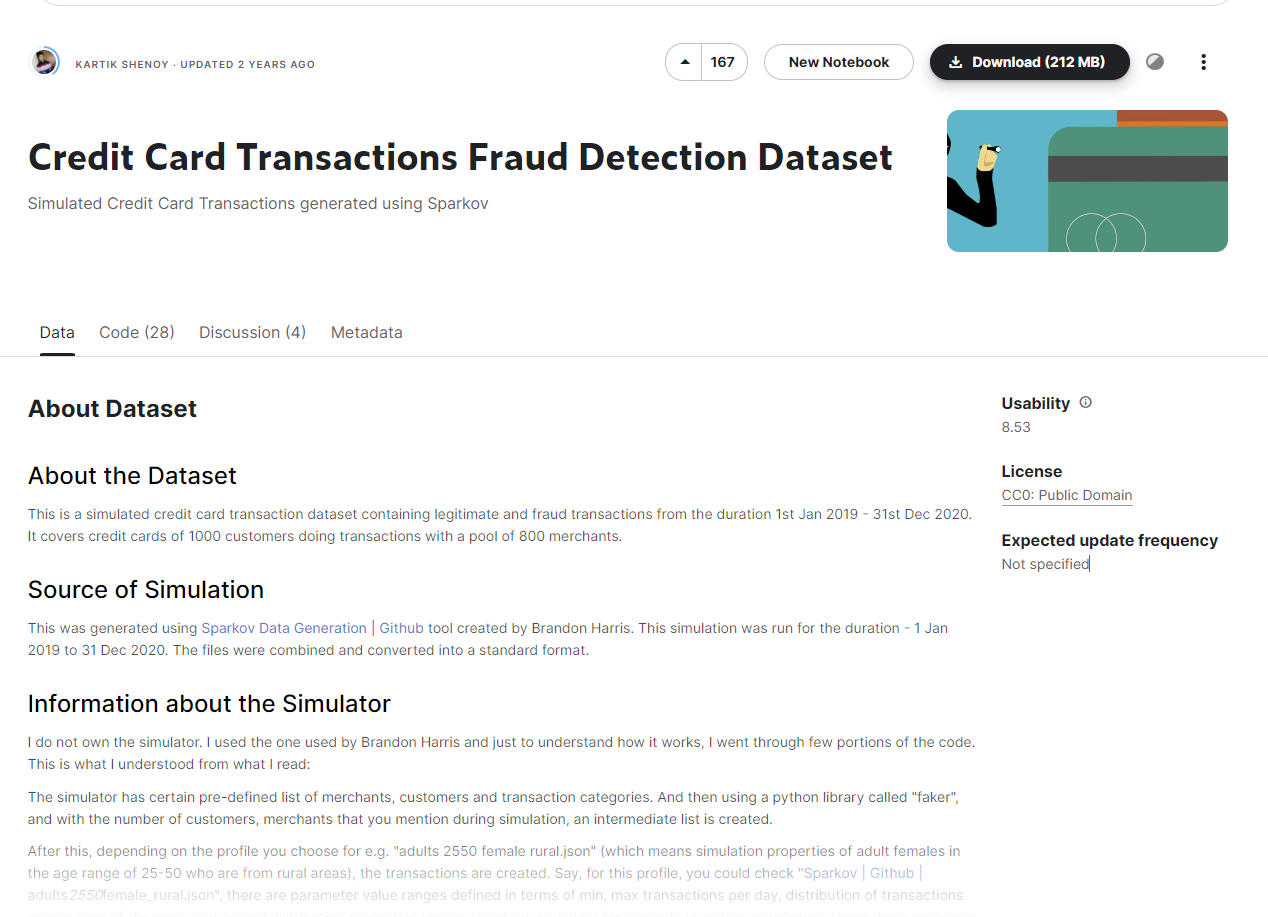

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import numpy as np
import datetime as dt
from pathlib import Path
from collections import Counter
import pandas as pd
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt

#  Import and read the fraudtrain.csv.
import pandas as pd 
ccf_df = pd.read_csv("Resources/fraudtrain.csv",parse_dates=['trans_date_trans_time',])

# Drop any null columns
ccf_df=ccf_df.dropna(axis='columns', how='all')
ccf_df.drop_duplicates(inplace=True)

# Drop all null rows
ccf_df= ccf_df.dropna()

# Preview 
ccf_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
# Extract frequencies of transactions in last 1/7/30 days
def last1DayTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_1_day').sort_index()
    count_1_day = temp.rolling('1d').count() - 1
    count_1_day.index = temp.values
    x['count_1_day'] = count_1_day.reindex(x.index)
    return x
def last7DaysTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_7_days').sort_index()
    count_7_days = temp.rolling('7d').count() - 1
    count_7_days.index = temp.values
    x['count_7_days'] = count_7_days.reindex(x.index)
    return x
def last30DaysTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_30_days').sort_index()
    count_30_days = temp.rolling('30d').count() - 1
    count_30_days.index = temp.values
    x['count_30_days'] = count_30_days.reindex(x.index)
    return x

In [4]:
# update to include if transaction in last 1 day
ccf_df1 = ccf_df.groupby('cc_num').apply(last1DayTransactionCount)

In [5]:
# update to include if transaction in last 7 days
ccf_df = ccf_df.groupby('cc_num').apply(last7DaysTransactionCount)

In [6]:
# update to include if transaction in last 30 days
ccf_df = ccf_df.groupby('cc_num').apply(last30DaysTransactionCount)

In [7]:
ccf_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,count_7_days,count_30_days
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.0,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0.0,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0.0,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0.0,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0.0,0.0


In [8]:
# Generate our categorical variable list
ccf_cat = ccf_df.dtypes[ccf_df.dtypes == "object"].index.tolist()

In [9]:
# Check the number of unique values in each column
ccf_df[ccf_cat].nunique()

merchant         693
category          14
first            352
last             481
gender             2
street           983
city             894
state             51
job              494
dob              968
trans_num    1296675
dtype: int64

In [10]:
# Create test DF to better understand object columns to drop
test_df = ccf_df

In [11]:
# Look at merchant value counts for binning
test_df.merchant.value_counts()

fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King                       775
fraud_Medhurst, Labadie and Gottlieb     759
fraud_Reichert-Weissnat                  753
fraud_Hahn, Douglas and Schowalter       727
Name: merchant, Length: 693, dtype: int64

<AxesSubplot:ylabel='Density'>

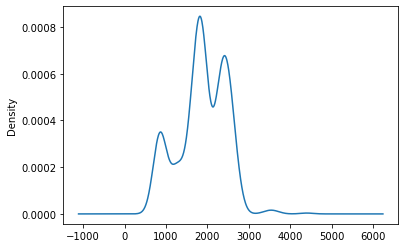

In [12]:
# Visualize the value counts of merchant type
type_count = test_df.merchant.value_counts()
type_count.plot.density()

In [13]:
# Determine which values to replace if counts are less than ...?
replace_merchant = list(type_count[type_count < 2725].index)

# Replace in dataframe
for app in replace_merchant:
    test_df.merchant = test_df.merchant.replace(app,"Other")
    
# Check to make sure binning was successful
test_df.merchant.value_counts()

Other                    1269082
fraud_Kilback LLC           4403
fraud_Cormier LLC           3649
fraud_Schumm PLC            3634
fraud_Kuhn LLC              3510
fraud_Boyer PLC             3493
fraud_Dickinson Ltd         3434
fraud_Cummerata-Jones       2736
fraud_Kutch LLC             2734
Name: merchant, dtype: int64

In [14]:
# Look at street value counts for binning
test_df.street.value_counts()

0069 Robin Brooks Apt. 695           3123
864 Reynolds Plains                  3123
8172 Robertson Parkways Suite 072    3119
4664 Sanchez Common Suite 930        3117
8030 Beck Motorway                   3113
                                     ... 
7281 Joshua Mills Apt. 077              7
3307 Ferguson Way                       7
9599 Washington Field Suite 238         7
3437 Ross Flat Apt. 592                 7
27954 Hall Mill Suite 575               7
Name: street, Length: 983, dtype: int64

<AxesSubplot:ylabel='Density'>

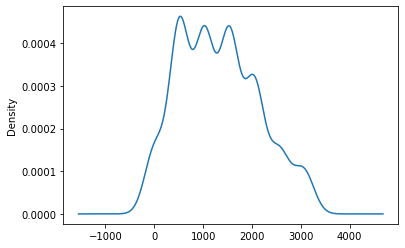

In [15]:
# Visualize the value counts of street type
type_count = test_df.street.value_counts()
type_count.plot.density()

In [16]:
# Look at city value counts for binning
test_df.city.value_counts()

Birmingham     5617
San Antonio    5130
Utica          5105
Phoenix        5075
Meridian       5060
               ... 
Vacaville         7
Claypool          7
Karns City        7
Bruce             7
Chattanooga       7
Name: city, Length: 894, dtype: int64

<AxesSubplot:ylabel='Density'>

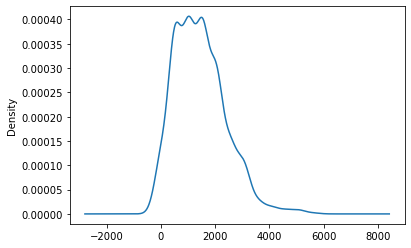

In [17]:
# Visualize the value counts of city type
type_count = test_df.city.value_counts()
type_count.plot.density()

In [18]:
# Determine which values to replace if counts are less than ...?
replace_city = list(type_count[type_count < 4500].index)

# Replace in dataframe
for app in replace_city:
    test_df.city = test_df.city.replace(app,"Other")
    
# Check to make sure binning was successful
test_df.city.value_counts()

Other          1252238
Birmingham        5617
San Antonio       5130
Utica             5105
Phoenix           5075
Meridian          5060
Thomas            4634
Conway            4613
Cleveland         4604
Warren            4599
Name: city, dtype: int64

In [19]:
# Look at job value counts for binning
test_df.job.value_counts()

Film/video editor             9779
Exhibition designer           9199
Naval architect               8684
Surveyor, land/geomatics      8680
Materials engineer            8270
                              ... 
Information officer              8
Veterinary surgeon               8
Ship broker                      7
Contracting civil engineer       7
Warehouse manager                7
Name: job, Length: 494, dtype: int64

<AxesSubplot:ylabel='Density'>

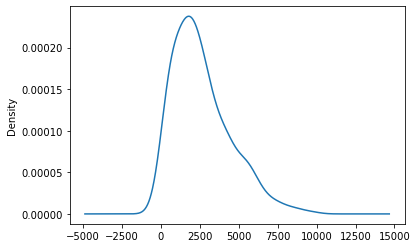

In [20]:
# Visualize the value counts of job type
type_count = test_df.job.value_counts()
type_count.plot.density()

In [21]:
# Determine which values to replace if counts are less than ...?
replace_job = list(type_count[type_count < 4500].index)

# Replace in dataframe
for app in replace_job:
    test_df.job = test_df.job.replace(app,"Other")
    
# Check to make sure binning was successful
test_df.job.value_counts()

Other                                    801189
Film/video editor                          9779
Exhibition designer                        9199
Naval architect                            8684
Surveyor, land/geomatics                   8680
                                          ...  
Engineer, control and instrumentation      4586
Radio broadcast assistant                  4583
Therapist, occupational                    4576
Surveyor, minerals                         4552
Educational psychologist                   4517
Name: job, Length: 86, dtype: int64

In [22]:
# Look at state value counts for binning
test_df.state.value_counts()

TX    94876
NY    83501
PA    79847
CA    56360
OH    46480
MI    46154
IL    43252
FL    42671
AL    40989
MO    38403
MN    31714
AR    31127
NC    30266
WI    29368
VA    29250
SC    29190
KY    28475
IN    27580
IA    26985
OK    26671
MD    26193
GA    26063
WV    25691
NJ    24603
NE    24168
KS    22996
MS    21188
LA    20965
WY    19322
WA    18924
OR    18597
TN    17554
ME    16505
NM    16407
ND    14786
CO    13880
MA    12376
SD    12324
VT    11768
MT    11754
AZ    10770
UT    10699
NH     8278
CT     7702
NV     5607
ID     5545
DC     3613
HI     2559
AK     2120
RI      550
DE        9
Name: state, dtype: int64

In [23]:
# Update fields to better reflect more legible items
ccf_df['age'] = dt.date.today().year-pd.to_datetime(ccf_df['dob']).dt.year
ccf_df['hour'] = pd.to_datetime(ccf_df['trans_date_trans_time']).dt.hour
ccf_df['day'] = pd.to_datetime(ccf_df['trans_date_trans_time']).dt.dayofweek
ccf_df['month'] = pd.to_datetime(ccf_df['trans_date_trans_time']).dt.month

#ccf_df2 = ccf_df.drop(columns = ['gender','category','cc_num','Unnamed: 0', 'trans_date_trans_time','merchant','dob', 'first', 'last', 'street', 'trans_num', 'city', 'job'])
ccf_df2 = ccf_df[['amt','state','is_fraud','count_7_days','count_30_days', 'age','hour','day','month']]


ccf_df2.head()

,amt,state,is_fraud,count_7_days,count_30_days,age,hour,day,month
0,4.97,NC,0,0.0,0.0,34,0,1,1
1,107.23,WA,0,0.0,0.0,44,0,1,1
2,220.11,ID,0,0.0,0.0,60,0,1,1
3,45.00,MT,0,0.0,0.0,55,0,1,1
4,41.96,VA,0,0.0,0.0,36,0,1,1


In [24]:
# Create a function to label states by region
def label_states (row):
    if row['state'] in ['VT', 'ME', 'NH', 'MA', 'RI', 'CT','NY','PA','NJ']:
        return 'North-East'
    if row['state'] in ['WI','MI','IL','IN','OH','ND','SD','NE','KS','MN','IA','MO']:
        return 'Mid-West'
    if row['state'] in ['DE','MD','DC','VA','WV','NC','SC','GA','FL','KY','TN','MS','AL','AR','LA']:
        return 'South-East'
    if row['state'] in ['OK','TX','NM','AZ']:
        return 'South-West'
    if row['state'] in ['CA','NV','UT','CO','WY','ID','OR','WA','MT','AK','HI']:
        return 'West'
    return 'etc'

In [25]:
# Add regions to each row of data
ccf_df2['Region']=ccf_df2.apply(lambda row: label_states(row), axis=1)

In [26]:
# Drop the state column and preview
ccf_df2 = ccf_df2.drop(columns = ['state'])
ccf_df2.head()

,amt,is_fraud,count_7_days,count_30_days,age,hour,day,month,Region
0,4.97,0,0.0,0.0,34,0,1,1,South-East
1,107.23,0,0.0,0.0,44,0,1,1,West
2,220.11,0,0.0,0.0,60,0,1,1,West
3,45.00,0,0.0,0.0,55,0,1,1,West
4,41.96,0,0.0,0.0,36,0,1,1,South-East


In [27]:
# Check the types of data in the columns
ccf_df2.dtypes

amt              float64
is_fraud           int64
count_7_days     float64
count_30_days    float64
age                int64
hour               int64
day                int64
month              int64
Region            object
dtype: object

In [28]:
# Convert category, gender & region to dummy variables
df=pd.get_dummies(ccf_df2, drop_first=True)
df

,amt,is_fraud,count_7_days,count_30_days,age,hour,day,month,Region_North-East,Region_South-East,Region_South-West,Region_West
0,4.97,0,0.0,0.0,34,0,1,1,0,1,0,0
1,107.23,0,0.0,0.0,44,0,1,1,0,0,0,1
2,220.11,0,0.0,0.0,60,0,1,1,0,0,0,1
3,45.00,0,0.0,0.0,55,0,1,1,0,0,0,1
4,41.96,0,0.0,0.0,36,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,0,21.0,86.0,61,12,6,6,0,0,0,1
1296671,51.70,0,6.0,30.0,43,12,6,6,0,1,0,0
1296672,105.93,0,36.0,139.0,55,12,6,6,0,0,1,0
1296673,74.90,0,24.0,133.0,42,12,6,6,0,0,0,0


In [29]:
# Split our preprocessed data into our features and target arrays
y = df["is_fraud"].values
X = df.drop(["is_fraud"], axis='columns').values

#Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

## SMOTE

In [30]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

method= SMOTE()
X_resampled, y_resampled = method.fit_resample(X_train, y_train)
model=LogisticRegression()
model.fit(X_resampled,y_resampled)
y_pred=model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matrix = confusion_matrix(y_test, y_pred)
# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    matrix, index=["True Valid", "True Fraud"], columns=["Predicted Valid", "Predicted Fraud"])
cm_df

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    322272
           1       0.07      0.75      0.13      1897

    accuracy                           0.94    324169
   macro avg       0.53      0.85      0.55    324169
weighted avg       0.99      0.94      0.96    324169



,Predicted Valid,Predicted Fraud
True Valid,303106,19166
True Fraud,475,1422


## Random Undersampling

In [31]:
#Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled1, y_resampled1 = ros.fit_resample(X_train, y_train)
Counter(y_resampled1)

Counter({0: 5609, 1: 5609})

In [32]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

model1 = LogisticRegression(solver='lbfgs', random_state=13)
model1.fit(X_resampled1, y_resampled1)
y_pred1=model1.predict(X_test)
balanced_accuracy_score(y_test, y_pred1)
report = classification_report_imbalanced(y_test, y_pred1)
print(report)
matrix1 = confusion_matrix(y_test, y_pred1)
# Create a DataFrame from the confusion matrix.
cm_df1 = pd.DataFrame(
    matrix1, index=["True Valid", "True Fraud"], columns=["Predicted Valid", "Predicted Fraud"])
cm_df1

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      0.75      0.97      0.84      0.72    322272
          1       0.07      0.75      0.94      0.13      0.84      0.69      1897

avg / total       0.99      0.94      0.75      0.96      0.84      0.72    324169



,Predicted Valid,Predicted Fraud
True Valid,303184,19088
True Fraud,471,1426


## SMOTEENN

In [33]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN
smote_df = SMOTEENN(random_state=13)
X_resampled2, y_resampled2 = smote_df.fit_resample(X, y)
print(Counter(y_resampled2))

Counter({1: 1289117, 0: 1268077})


In [34]:
# Train the Logistic Regression model using the resampled data
model2 = LogisticRegression(solver='lbfgs', random_state=13)
model2.fit(X_resampled2,y_resampled2)

LogisticRegression(random_state=13)

In [35]:
# Calculated the balanced accuracy score
y_pred2 = model2.predict(X_test)
balanced_accuracy_score(y_test, y_pred2)

0.8443230506406622

In [37]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred2))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      0.75      0.97      0.84      0.72    322272
          1       0.07      0.75      0.94      0.12      0.84      0.69      1897

avg / total       0.99      0.94      0.75      0.96      0.84      0.72    324169



In [36]:
# Display the confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)

# Create a DataFrame from the confusion matrix.
cm2_df = pd.DataFrame(
    cm2, index=["True Valid", "True Fraud"], columns=["Predicted Valid", "Predicted Fraud"])

cm3_df

,Predicted Valid,Predicted Fraud
True Valid,302287,19985
True Fraud,473,1424


## Random Oversampling

In [38]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros1 = RandomOverSampler(random_state=13)
X_resampled3,y_resampled3 = ros1.fit_resample(X_train,y_train)
Counter(y_resampled3)

Counter({0: 966897, 1: 966897})

In [39]:
# Train the Logistic Regression model using the resampled data
model3 = LogisticRegression(solver='lbfgs', random_state=13)
model3.fit(X_resampled3,y_resampled3)

LogisticRegression(random_state=13)

In [40]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred3 = model3.predict(X_test)
balanced_accuracy_score(y_test, y_pred3)

0.8473298275247849

In [41]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred3))
matrix3 = confusion_matrix(y_test, y_pred3)
# Create a DataFrame from the confusion matrix.
cm_df3 = pd.DataFrame(
    matrix3, index=["Valid", "Fraud"], columns=["Predicted Valid", "Predicted Fraud"])
cm_df3


                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      0.75      0.97      0.84      0.72    322272
          1       0.07      0.75      0.94      0.13      0.84      0.69      1897

avg / total       0.99      0.94      0.75      0.97      0.84      0.72    324169



,Predicted Valid,Predicted Fraud
Valid,304225,18047
Fraud,473,1424


## Random Forest

In [43]:
#random forest 
from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier(random_state=13)
model4.fit(X_resampled,y_resampled)
y_pred4=model4.predict(X_test)
report = classification_report(y_test, y_pred4)
print(report)
matrix4 = confusion_matrix(y_test, y_pred4)

# Display the confusion matrix
cm4 = confusion_matrix(y_test, y_pred4)

# Create a DataFrame from the confusion matrix.
cm_df4 = pd.DataFrame(
    cm4, index=["True Valid", "True Fraud"], columns=["Predicted Valid", "Predicted Fraud"])

cm_df4

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322272
           1       0.72      0.68      0.70      1897

    accuracy                           1.00    324169
   macro avg       0.86      0.84      0.85    324169
weighted avg       1.00      1.00      1.00    324169

[[304225  18047]
 [   473   1424]]


,Predicted Valid,Predicted Fraud
True Valid,321760,512
True Fraud,598,1299
